In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.1 MB/s eta 0:00:00


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mode

import xgboost as xgb

import pymc as pm
import pymc_bart as bart
import arviz as az

# Fluency Classification

In [ ]:
df = pd.read_csv('audio_features.csv')

In [ ]:
df.head()

,filename,fluent,mfcc_1_mean,mfcc_1_std,mfcc_1_min,mfcc_1_max,mfcc_2_mean,mfcc_2_std,mfcc_2_min,mfcc_2_max,...,f0_std,f0_min,f0_max,f0_range,voicing_ratio,rms_mean,rms_std,rms_min,rms_max,rms_silence_ratio
0,alg2 (kabyle1).mp3,1,-249.161224,82.340042,-0.009177,11.734279,-5.877758,3.598008,-13.824122,7.582335,...,51.402558,65.406391,401.157895,335.751504,0.729487,0.057814,0.048480,2.230768e-05,0.250718,0.340465
1,mor1 (arabic16).mp3,1,-335.557739,36.862637,56.727058,32.562382,7.290244,-13.695300,-5.236850,3.017725,...,13.720698,84.821595,160.121850,75.300255,0.664557,0.043067,0.026000,5.113224e-07,0.143564,0.139080
2,mor13 (arabic199).mp3,1,-346.905090,59.868484,20.586031,10.380270,-9.471201,10.675188,-5.354011,-19.770229,...,44.157383,175.625645,369.994423,194.368778,0.594268,0.033390,0.026803,1.820597e-07,0.144091,0.274918
3,mor15 (amazigh2).mp3,1,-301.734253,113.287285,19.388758,22.271446,15.049973,-11.677243,5.139485,-3.861141,...,19.172727,65.406391,210.065153,144.658762,0.704986,0.052135,0.039502,8.080930e-06,0.204652,0.261307
4,mor2 (arabic17).mp3,1,-324.137604,62.490353,50.893974,21.064720,3.662904,-5.984343,-2.097588,7.498139,...,11.174934,90.909535,176.643034,85.733499,0.690000,0.075353,0.061941,4.152006e-07,0.235493,0.280829


In [ ]:
# Number of fluent vs nonfluent speakers
print("Number of fluent speakers:", len(df[df['fluent'] == 1]))
print("Number of nonfluent speakers:", len(df[df['fluent'] == 0]))

Number of fluent speakers: 179
Number of nonfluent speakers: 292


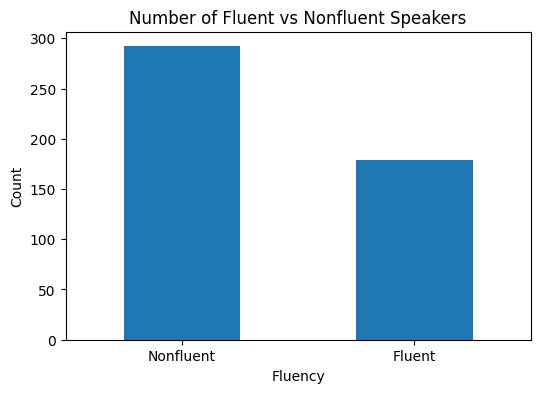

In [ ]:
# Plot of fluent vs nonfluent speakers
counts = df['fluent'].value_counts()
plt.figure(figsize=(6, 4))
counts.plot(kind='bar')
plt.xticks([0, 1], ['Nonfluent', 'Fluent'], rotation=0)
plt.xlabel('Fluency')
plt.ylabel('Count')
plt.title('Number of Fluent vs Nonfluent Speakers')
plt.show()

In [ ]:
# Preprocess dataframe for X and Y train and test sets
X = df.drop(columns=["filename", "fluent"])
Y = df["fluent"]
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
X.shape, Y.shape, x_train.shape, y_train.shape

((471, 251), (471,), (376, 251), (376,))

### Random Forest model for fluency classification

In [ ]:
# Random Forest Model
RF_model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=10,
    bootstrap=False,
    class_weight='balanced',
    random_state=42
)
RF_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_split=10, n_estimators=1000,
                       random_state=42)

In [ ]:
# Evaluate RF model performance
y_pred = RF_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6105263157894737
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71        59
           1       0.48      0.33      0.39        36

    accuracy                           0.61        95
   macro avg       0.57      0.56      0.55        95
weighted avg       0.59      0.61      0.59        95



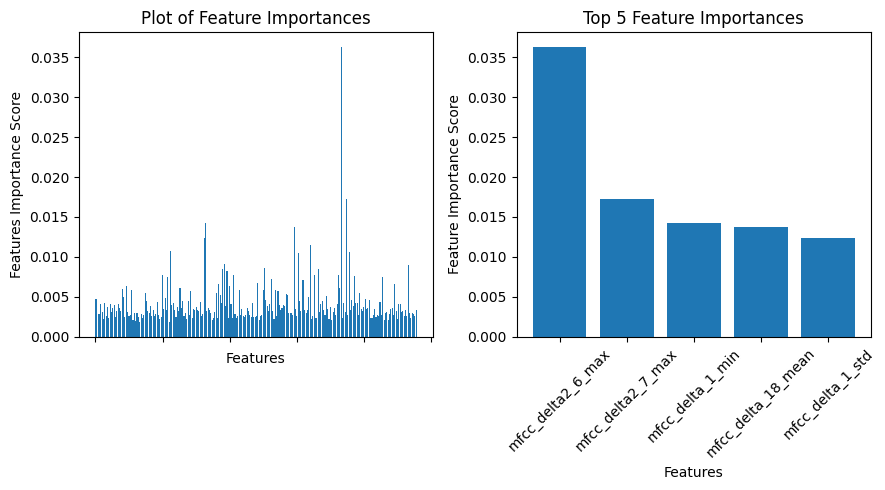

In [ ]:
# Extract and plot feature importances according to RF model
importances = RF_model.feature_importances_
top_idx = np.argsort(importances)[-5:][::-1]
top_features = [X.columns[i] for i in top_idx]
top_importances = importances[top_idx]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))

axes[0].bar(range(len(importances)), importances)
axes[0].set_xticklabels([])
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Features Importance Score')
axes[0].set_title("Plot of Feature Importances")

axes[1].bar(top_features, top_importances)
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Feature Importance Score')
axes[1].set_title('Top 5 Feature Importances')

plt.tight_layout()
plt.show()

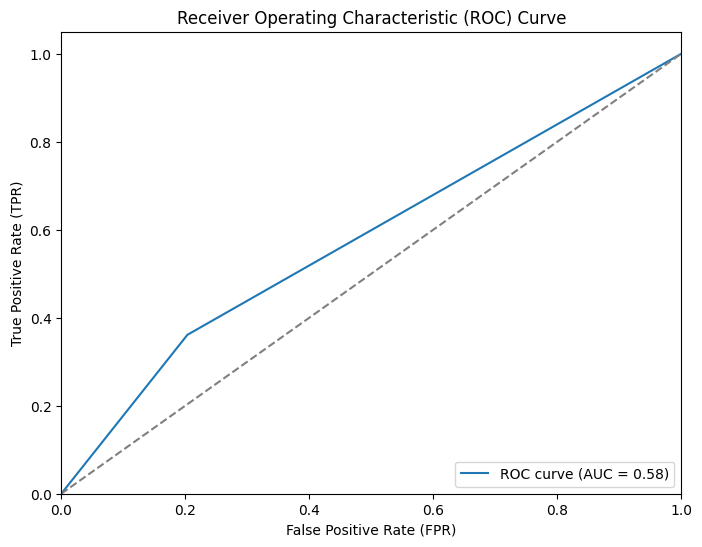

In [ ]:
# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Random Forest Model with Grid Search
param_grid = [{
    'bootstrap': [False, True],
    'n_estimators': [100, 500, 1000, 2000],
    'min_samples_split': [2, 5, 10, 15],
    'max_features': [2, 3, 4],
    'class_weight': ['balanced', None]
}]
RF_GridSearch_model = RandomForestClassifier()
grid_search = GridSearchCV(RF_GridSearch_model, param_grid,
                           scoring='accuracy', refit=True,
                           return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'bootstrap': [False, True],
                          'class_weight': ['balanced', None],
                          'max_features': [2, 3, 4],
                          'min_samples_split': [2, 5, 10, 15],
                          'n_estimators': [100, 500, 1000, 2000]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 4, 'min_samples_split': 15, 'n_estimators': 500}
Best cross-validation score: 0.710


In [ ]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_features': 3, 'min_samples_split': 15, 'n_estimators': 500}
Best cross-validation score: 0.721


In [ ]:
# Random Forest Model with Grid search
RF_model = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    max_features=grid_search.best_params_['max_features'],
    bootstrap=grid_search.best_params_['bootstrap'],
    class_weight=grid_search.best_params_['class_weight'],
)
RF_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=4,
                       min_samples_split=15, n_estimators=500)

In [ ]:
# Evaluate RF with Grid Search model performance
y_pred = RF_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5684210526315789
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.81      0.70        59
           1       0.35      0.17      0.23        36

    accuracy                           0.57        95
   macro avg       0.48      0.49      0.46        95
weighted avg       0.52      0.57      0.52        95



### XGBoost model for fluency classification

In [ ]:
# Train and fit XGBoost model
boost = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=3)
boost.fit(x_train, y_train, eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:0.65530
[1]	validation_0-logloss:0.66407
[2]	validation_0-logloss:0.66801
[3]	validation_0-logloss:0.69251


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=3,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Get scores
train_score = boost.score(x_train, y_train)
test_score = boost.score(x_test, y_test)
print("Train score:", train_score)
print("Test score:", test_score)

Train score: 0.8776595744680851
Test score: 0.6526315789473685


In [ ]:
# Evaluate XGBoost model performance
y_pred = boost.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6526315789473685
Classification report:
               precision    recall  f1-score   support

           0       0.69      0.80      0.74        59
           1       0.56      0.42      0.48        36

    accuracy                           0.65        95
   macro avg       0.62      0.61      0.61        95
weighted avg       0.64      0.65      0.64        95



In [ ]:
# Train and fit XGBoost model
boost = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
boost.fit(x_train, y_train, eval_set=[(x_test, y_test)])

[0]	validation_0-logloss:0.65530
[1]	validation_0-logloss:0.66407
[2]	validation_0-logloss:0.66801


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Get scores
train_score = boost.score(x_train, y_train)
test_score = boost.score(x_test, y_test)
print("Train score:", train_score)
print("Test score:", test_score)

Train score: 0.8776595744680851
Test score: 0.6526315789473685


In [ ]:
# Evaluate XGBoost model performance
y_pred = boost.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6526315789473685
Classification report:
               precision    recall  f1-score   support

           0       0.69      0.80      0.74        59
           1       0.56      0.42      0.48        36

    accuracy                           0.65        95
   macro avg       0.62      0.61      0.61        95
weighted avg       0.64      0.65      0.64        95



### BART model for fluency classification

In [ ]:
with pm.Model() as BART_model:

    # Set X data
    x_data = pm.Data('X', x_train)

    # BART
    mu = bart.BART('mu', x_data, y_train, m=50)

    # Probability p and likelihood
    p = pm.Deterministic('p', pm.math.sigmoid(mu))
    pm.Bernoulli('likelihood', p=p, observed=y_train, shape=mu.shape)

    trace = pm.sample(2000, tune=1000)
    pm.sample_posterior_predictive(trace)

Output()

Output()

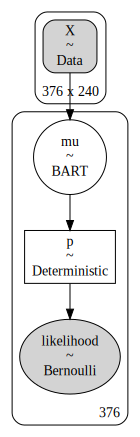

In [ ]:
# Visualize model
pm.model_to_graphviz(model=BART_model)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

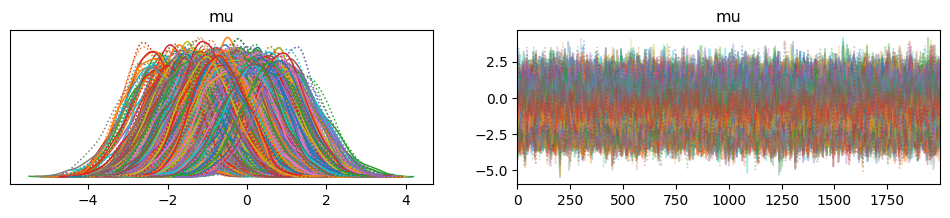

In [ ]:
# Plot trace for BART mu
az.plot_trace(trace, var_names=["mu"])

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

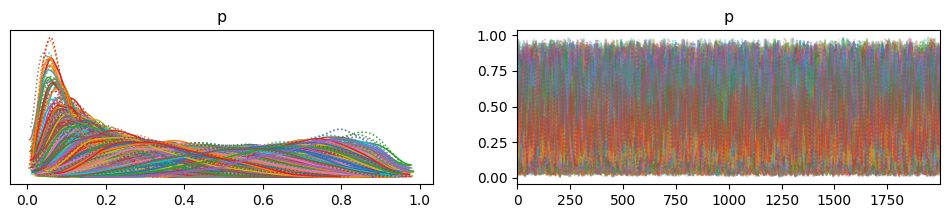

In [ ]:
# Plot trace for probabilities p
az.plot_trace(trace, var_names=['p'])

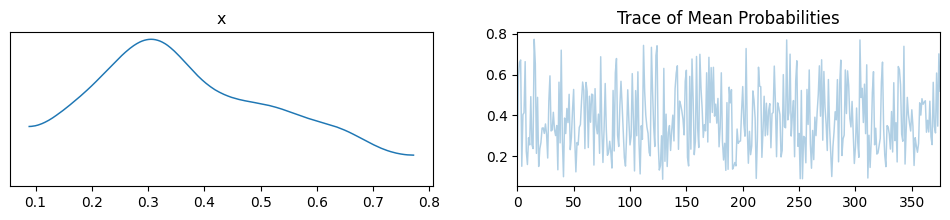

In [ ]:
# Plot trace for mean of p
p_mean = trace.posterior["p"].mean(dim=['chain', 'draw']).values
az.plot_trace(p_mean)
plt.title("Trace of Mean Probabilities")
plt.show()

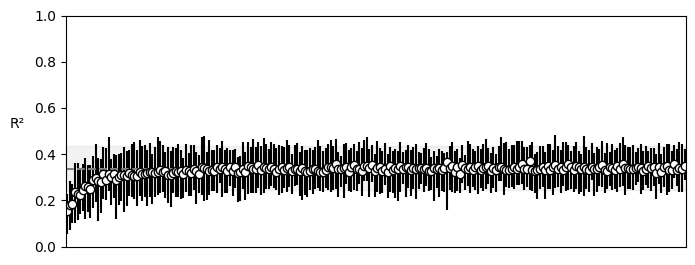

In [ ]:
# Calculate and plot variable importance from BART
bart_importances = bart.compute_variable_importance(trace, mu, x_train, method="VI")
bart.plot_variable_importance(bart_importances)
plt.xticks([])
plt.show()

In [ ]:
# Convert probabilities to predictions
y_pred = (p_mean > 0.5).astype(int)

# Model evaluation on training data
print("Train accuracy:", accuracy_score(y_train, y_pred))
print("Train classification report:\n", classification_report(y_train, y_pred))

Train accuracy: 0.8351063829787234
Train classification report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88       233
           1       0.93      0.62      0.74       143

    accuracy                           0.84       376
   macro avg       0.87      0.79      0.81       376
weighted avg       0.85      0.84      0.83       376



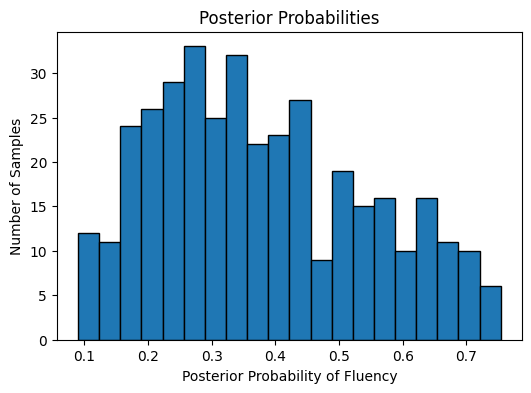

In [ ]:
# Plot posterior probabilities
plt.figure(figsize=(6, 4))
plt.hist(p_mean, bins=20, edgecolor='black')
plt.xlabel('Posterior Probability of Fluency')
plt.ylabel('Number of Samples')
plt.title('Posterior Probabilities')
plt.show()

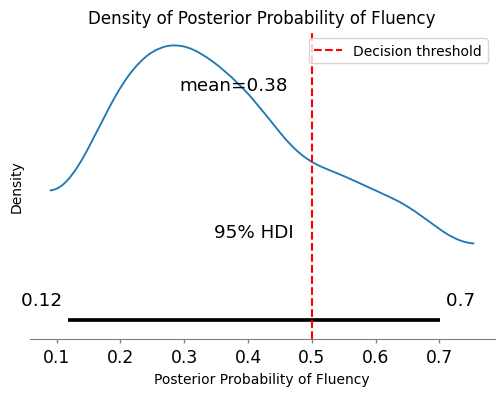

In [ ]:
# Plot posterior probability density
az.plot_posterior(p_mean, hdi_prob=0.95, figsize=(6, 4))
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel('Posterior Probability of Fluency')
plt.ylabel('Density')
plt.title('Density of Posterior Probability of Fluency')
plt.legend()
plt.show()

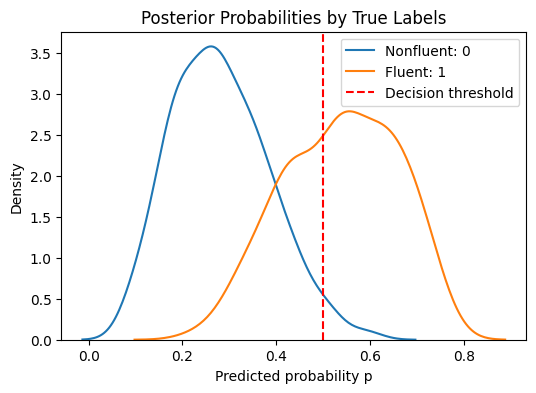

In [ ]:
# Plot of posterior probability density by true labels
plt.figure(figsize=(6, 4))
sns.kdeplot(p_mean[y_train==0], label='Nonfluent: 0')
sns.kdeplot(p_mean[y_train==1], label='Fluent: 1')
plt.axvline(0.5, color='red', linestyle='--', label='Decision threshold')
plt.xlabel("Predicted probability p")
plt.title("Posterior Probabilities by True Labels")
plt.legend()
plt.show()

In [ ]:
# BART model on test data
with BART_model:
    pm.set_data({'X': x_test})
    ppc_test = pm.sample_posterior_predictive(trace, predictions=True)

Output()

In [ ]:
# Get predictions from test data
pred_values = ppc_test.predictions['likelihood']
pred_means = pred_values.mean(dim=['chain', 'draw']).values
y_pred = (pred_means > 0.5).astype(int)

# Evaluate model performance
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test classification report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.6421052631578947
Test classification report:
               precision    recall  f1-score   support

           0       0.67      0.85      0.75        59
           1       0.55      0.31      0.39        36

    accuracy                           0.64        95
   macro avg       0.61      0.58      0.57        95
weighted avg       0.62      0.64      0.61        95



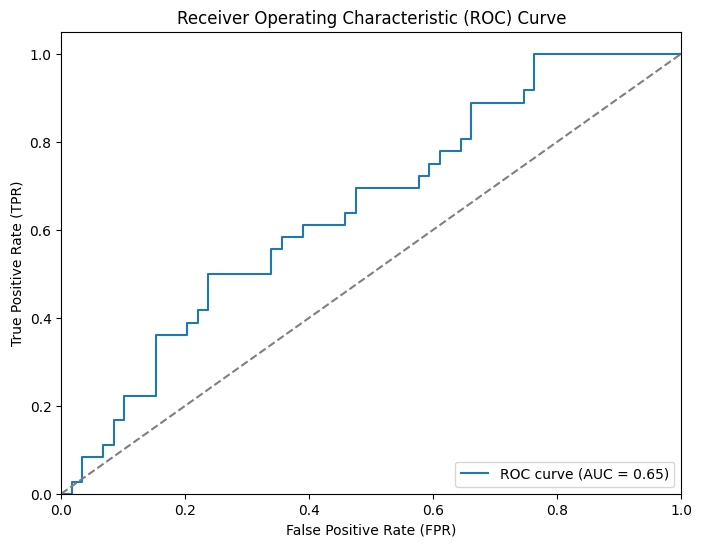

In [ ]:
# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred_means)
roc_auc = roc_auc_score(y_test, pred_means)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save AUC-ROC score
scores = {}

# Testing BART model with m=25, m=100, and m=200
m_trees = [25, 100, 200]
for m in m_trees:

    with pm.Model() as BART_model_m:
        x_data = pm.Data('X', x_train)
        mu = bart.BART('mu', x_data, y_train, m=m)
        p = pm.Deterministic('p', pm.math.sigmoid(mu))
        pm.Bernoulli('likelihood', p=p, observed=y_train, shape=mu.shape)
        trace = pm.sample(2000, tune=1000)
        pm.sample_posterior_predictive(trace)

    # Train
    print(f"For m={m} train set")
    p_samples = trace.posterior['p']
    p_means = p_samples.mean(dim=['chain','draw']).values
    y_pred = (p_means > 0.5).astype(int)
    accuracy = accuracy_score(y_train, y_pred)
    report = classification_report(y_train, y_pred)
    print(f"Train accuracy for m={m}:", accuracy)
    print(f"Train classification report for m={m}:\n", report)

    # Test
    print(f"\nFor m={m} test set")
    with BART_model_m:
        pm.set_data({'X': x_test})
        ppc_test = pm.sample_posterior_predictive(trace, predictions=True)
    pred_values = ppc_test.predictions['likelihood']
    pred_means = pred_values.mean(dim=['chain', 'draw']).values
    y_pred = (pred_means > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Test accuracy for m={m}:", accuracy)
    print(f"Test classification report for m={m}:\n", report)

    # Save AUC-ROC for m
    fpr, tpr, thresholds = roc_curve(y_test, pred_means)
    roc_auc = roc_auc_score(y_test, pred_means)
    scores[str(m)] = (fpr, tpr, roc_auc)

Output()

Output()

Output()

For m=25 train set
Train accuracy for m=25: 0.7925531914893617
Train classification report for m=25:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85       233
           1       0.95      0.48      0.64       143

    accuracy                           0.79       376
   macro avg       0.85      0.73      0.75       376
weighted avg       0.83      0.79      0.77       376


For m=25 test set


Test accuracy for m=25: 0.6421052631578947
Test classification report for m=25:
               precision    recall  f1-score   support

           0       0.65      0.90      0.76        59
           1       0.57      0.22      0.32        36

    accuracy                           0.64        95
   macro avg       0.61      0.56      0.54        95
weighted avg       0.62      0.64      0.59        95



Output()

Output()

Output()

For m=100 train set
Train accuracy for m=100: 0.8829787234042553
Train classification report for m=100:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       233
           1       0.95      0.73      0.83       143

    accuracy                           0.88       376
   macro avg       0.90      0.85      0.87       376
weighted avg       0.89      0.88      0.88       376


For m=100 test set


Test accuracy for m=100: 0.6210526315789474
Test classification report for m=100:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73        59
           1       0.50      0.28      0.36        36

    accuracy                           0.62        95
   macro avg       0.58      0.55      0.54        95
weighted avg       0.60      0.62      0.59        95



Output()

Output()

Output()

For m=200 train set
Train accuracy for m=200: 0.9228723404255319
Train classification report for m=200:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       233
           1       0.97      0.82      0.89       143

    accuracy                           0.92       376
   macro avg       0.94      0.90      0.92       376
weighted avg       0.93      0.92      0.92       376


For m=200 test set


Test accuracy for m=200: 0.6210526315789474
Test classification report for m=200:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72        59
           1       0.50      0.36      0.42        36

    accuracy                           0.62        95
   macro avg       0.58      0.57      0.57        95
weighted avg       0.60      0.62      0.61        95



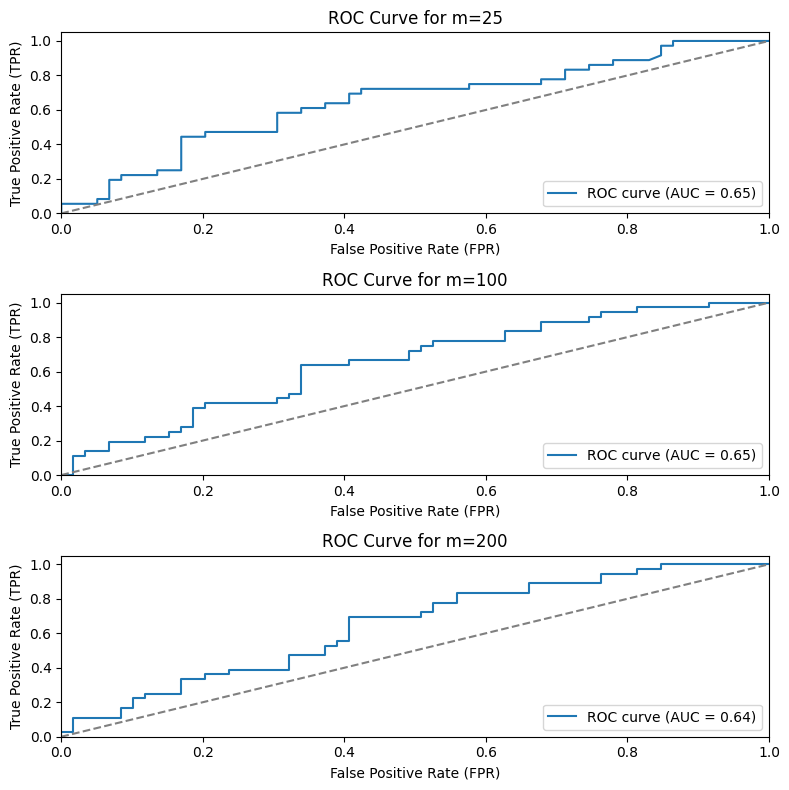

In [ ]:
# Show ROC curves for m=25, m=100, and m=200
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
i = 0
for key in scores.keys():
    ax = axes[i]
    ax.plot(scores[key][0], scores[key][1],
            label=f'ROC curve (AUC = {scores[key][2]:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title(f'ROC Curve for m={key}')
    ax.legend(loc='lower right')
    i += 1

plt.tight_layout()
plt.show()

# Accent Classification

In [ ]:
df_accents = pd.read_csv('accent_features.csv')

In [ ]:
df_accents.head()

,filename,accent,mfcc_1_mean,mfcc_1_std,mfcc_1_min,mfcc_1_max,mfcc_2_mean,mfcc_2_std,mfcc_2_min,mfcc_2_max,...,mfcc_delta2_18_min,mfcc_delta2_18_max,mfcc_delta2_19_mean,mfcc_delta2_19_std,mfcc_delta2_19_min,mfcc_delta2_19_max,mfcc_delta2_20_mean,mfcc_delta2_20_std,mfcc_delta2_20_min,mfcc_delta2_20_max
0,irq1 (arabic12).mp3,iraq (irq),-391.361908,44.173599,-16.947355,25.173721,-17.010973,-8.685701,-6.328293,-11.124125,...,6.119689,5.745418,6.088083,4.777244,4.397236,4.914296,6.709456,5.115982,4.315251,3.767845
1,irq10 (arabic92).mp3,iraq (irq),-293.398926,70.160545,-7.702625,13.037015,-2.945370,-12.689965,-17.945042,-21.496141,...,3.821947,3.519572,4.208102,3.197717,2.345327,2.445092,2.844004,2.197459,3.544385,2.057992
2,irq11 (arabic93).mp3,iraq (irq),-352.309387,59.571754,-3.129126,6.420524,-20.060772,-5.873501,-9.413985,-14.072992,...,5.081609,4.345273,4.888814,4.167799,3.297168,3.218363,3.180647,2.850305,2.967915,3.038970
3,irq12 (arabic103).mp3,iraq (irq),-300.404419,117.462463,16.858852,17.892780,-15.882438,-8.973602,-13.919630,-2.153141,...,4.209112,4.158511,3.956862,4.253977,3.850168,3.107841,2.876928,3.940235,2.999099,2.591510
4,irq13 (kurdish1).mp3,iraq (irq),-311.523651,117.236008,20.062746,33.695774,14.345624,0.253668,4.367611,-0.932156,...,4.615890,3.717632,3.983800,3.269038,2.930776,3.452594,2.490468,2.806595,2.414162,2.465549


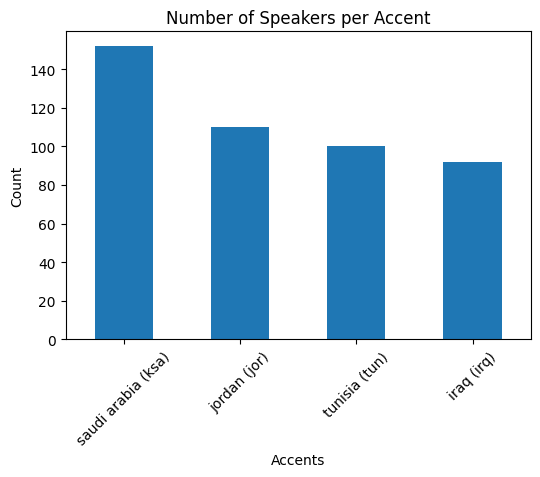

In [ ]:
# Plot of accents and counts
counts = df_accents['accent'].value_counts()
plt.figure(figsize=(6, 4))
counts.plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Accents')
plt.ylabel('Count')
plt.title('Number of Speakers per Accent')
plt.show()

In [ ]:
# Preprocess dataframe for X and Y train and test sets
X = df_accents.drop(columns=["filename", "accent"])
Y = df_accents["accent"].map({'iraq (irq)': 0, 'jordan (jor)': 1,
                              'saudi arabia (ksa)': 2, 'tunisia (tun)': 3})
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
X.shape, Y.shape, x_train.shape, y_train.shape

((454, 240), (454,), (363, 240), (363,))

### Random Forest model for accent classification

In [ ]:
# Random Forest Model
RF_model = RandomForestClassifier(
    n_estimators=1000,
    min_samples_split=10,
    bootstrap=False,
    class_weight='balanced',
    random_state=42
)

In [ ]:
# Run model
RF_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       min_samples_split=10, n_estimators=1000,
                       random_state=42)

In [ ]:
# Evaluate RF model performance
y_pred = RF_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4725274725274725
Classification report:
               precision    recall  f1-score   support

           0       0.25      0.06      0.09        18
           1       0.32      0.27      0.29        22
           2       0.54      0.81      0.65        31
           3       0.50      0.55      0.52        20

    accuracy                           0.47        91
   macro avg       0.40      0.42      0.39        91
weighted avg       0.42      0.47      0.43        91



### BART model for accent classification

In [ ]:
# Split into equal train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42, stratify=Y
)
x_train.shape, y_train.shape

((227, 240), (227,))

In [ ]:
with pm.Model() as BART_accent_model:
    x_data = pm.Data("X", x_train)
    mu = bart.BART("mu", x_data, y_train, m=50, shape=x_data.shape)
    p = pm.Deterministic("p", pm.math.softmax(mu, axis=0))
    pm.Categorical("likelihood", p=p.T, observed=y_train)

    trace = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(trace)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [ ]:
# Probabilities from samples
p_samples = trace.posterior["p"]
p_means = p_samples.mean(dim=["draw", "chain"])
y_train_pred = p_means.argmax(dim="p_dim_0").values

# Model evaluation on training data
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification report:\n", classification_report(y_train, y_train_pred))

Accuracy: 0.7797356828193832
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.41      0.57        46
           1       0.77      0.80      0.79        55
           2       0.74      0.95      0.83        76
           3       0.81      0.84      0.82        50

    accuracy                           0.78       227
   macro avg       0.81      0.75      0.75       227
weighted avg       0.80      0.78      0.77       227



In [ ]:
# BART model on test data
with BART_accent_model:
    pm.set_data({'X': x_test})
    ppc_test = pm.sample_posterior_predictive(trace, predictions=True)

Output()

In [ ]:
# Get predictions based on mode
y_test_pred = ppc_test.predictions['likelihood'].stack(sample=("chain", "draw"))
y_pred = mode(y_test_pred.values.T, axis=0)[0]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("BART accuracy:", accuracy)
print("BART classification report:\n", classification_report(y_test, y_pred))

BART accuracy: 0.5022026431718062
BART classification report:
               precision    recall  f1-score   support

           0       0.57      0.17      0.27        46
           1       0.40      0.35      0.37        55
           2       0.53      0.83      0.64        76
           3       0.53      0.48      0.51        50

    accuracy                           0.50       227
   macro avg       0.51      0.46      0.45       227
weighted avg       0.50      0.50      0.47       227

